# Introduktion till Jupyter notebook

Exempel på hur man kan lösa uppgift 1 med hjälp av Jupyter notebook.





## Läsa in data

Det första vi behöver göra är att läsa in vår data. Det går att använda i princip vilken källa som helst för att läsa in data i Jupyter notebooks. Det vanligaste är att man läser in csv-filer, men det går också att läsa in data från ett API (t.ex. Google Analytics reporting API), en databas (t.ex. databasen för vårt e-handelssystem), eller från BigQuery. Eftersom vi gjort oss besväret att lägga upp ett Data warehouse i BigQuery så drar vi nytta av det och hämtar vår data därifrån.

Det första vi behöver göra är att ansluta oss till BigQuery. Vi gör det med följande kod:

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


När vi har kört koden ovan kan vi enkelt läsa in vår Google Analytics data från BigQuery med en SQL-sats och spara resultatet i en Dataframe med namnet *ga_report*:

In [0]:
%%bigquery --project surfsapp-8011b ga_report
SELECT distinct
  dimension1,
  start_date,
  campaign,
  sourcemedium,
  sessions,
  transactions,
  pageviews,
  transactionrevenue
FROM `surfsapp-8011b.google_analytics.report` 
where start_date between '2019-11-06' and '2019-11-13'

Dataframes är en del av Pythons dataanalys-bilbliotek pandas (https://pandas.pydata.org/). En Dataframe är helt enkelt en tabell med data, och vi kan vi kan få en snabb överblick av innehållet genom att kolla på de fem första raderna med följande kommando:

In [3]:
ga_report.head()

,dimension1,start_date,campaign,sourcemedium,sessions,transactions,pageviews,transactionrevenue
0,135193,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,24,0
1,135334,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,6,0
2,135355,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,5,0
3,135365,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,14,0
4,135369,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,9,0


Vi kan få lite ytterligare information om vilka datatyper de olika kolumnerna har med följande kommando:

In [4]:
ga_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492 entries, 0 to 3491
Data columns (total 8 columns):
dimension1            3492 non-null object
start_date            3492 non-null datetime64[ns, UTC]
campaign              3492 non-null object
sourcemedium          3492 non-null object
sessions              3492 non-null int64
transactions          3492 non-null int64
pageviews             3492 non-null int64
transactionrevenue    3492 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 218.4+ KB


En intressant observation ovan är att transactionrevenue har datatypen *object* (d.vs. text) och inte *int64* (d.v.s. numeriskt värde). Vi kan rätta till detta genom att omvandla värdena i kolumnen till *int64*:

In [5]:
ga_report['transactionrevenue']=ga_report['transactionrevenue'].astype(str).astype('int64')

ga_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492 entries, 0 to 3491
Data columns (total 8 columns):
dimension1            3492 non-null object
start_date            3492 non-null datetime64[ns, UTC]
campaign              3492 non-null object
sourcemedium          3492 non-null object
sessions              3492 non-null int64
transactions          3492 non-null int64
pageviews             3492 non-null int64
transactionrevenue    3492 non-null int64
dtypes: datetime64[ns, UTC](1), int64(4), object(3)
memory usage: 218.4+ KB


Nu när vi har rätt datatyper kan använda funktionen *describe* för att få en snabb överblick av vilka värden våra metrics har:

In [6]:
ga_report.describe()

,sessions,transactions,pageviews,transactionrevenue
count,3492.000000,3492.000000,3492.000000,3492.000000
mean,1.188717,0.327606,13.351088,6455.004582
std,0.501683,0.557550,8.070507,13481.824583
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,8.000000,0.000000
50%,1.000000,0.000000,11.000000,0.000000
75%,1.000000,1.000000,16.000000,6229.000000
max,7.000000,4.000000,83.000000,126087.000000


Vi kan också göra en parvis plottning av mätvärdena för att se om det finns några samband mellan dessa:

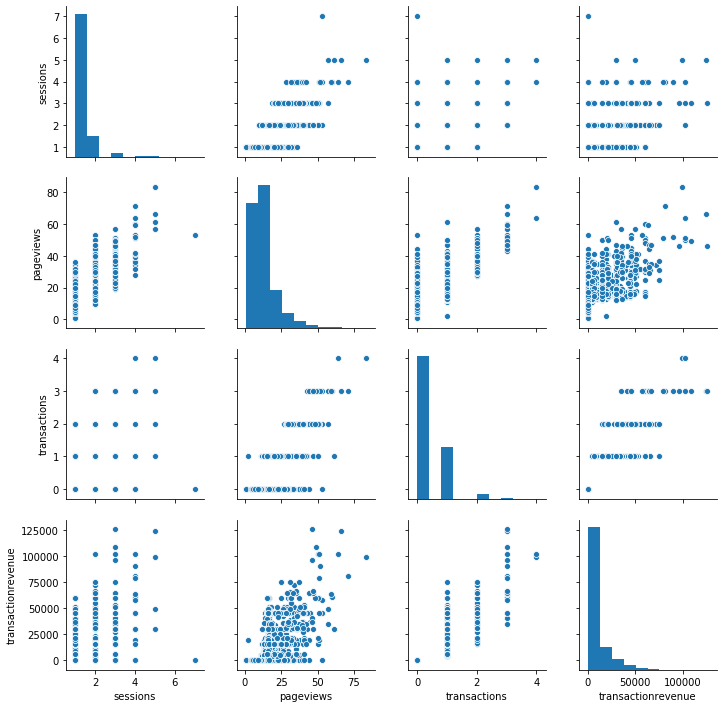

In [9]:
import seaborn as sns

sns.pairplot(ga_report[['sessions',	'pageviews', 'transactions', 'transactionrevenue']]);

Vi kan t.ex. se att det finns ett tydligt samband mellan antalet pageviews och antalet transaktioner samt transaktionsvärde, medan det inte ser ut att finnas något tydligt samband mellan antalet sessions och antalet transaktioner.

Låt oss dock vänta med själva analyserandet och istället ladda in vår kunddata. Även denna ligger i BigQuery och vi använder en SQL-sats för att läsa in denna i en dataframe med namnet customer_data:

In [0]:
%%bigquery --project surfsapp-8011b customer_data
select distinct a.EntityId CustomerID, a.value Gender, b.value DateOfBirth, d.ZipPostalCode 
from `surfsapp-8011b.nop_database.GenericAttribute` a
inner join `surfsapp-8011b.nop_database.GenericAttribute` b on a.EntityId=b.EntityId
left outer join `surfsapp-8011b.nop_database.CustomerAddresses` c on c.Customer_Id=b.EntityId
left outer join `surfsapp-8011b.nop_database.Address` d on d.Id=c.Address_Id
where a.key = 'Gender' and b.Key = 'DateOfBirth'

Nu kan vi igen använda oss av funktionen head för att se de första raderna i vår dataframe: 

In [11]:
customer_data.head()

,CustomerID,Gender,DateOfBirth,ZipPostalCode
0,135441,M,1958-08-03,40010
1,142920,M,1962-08-03,20800
2,139852,F,1965-08-03,20800
3,136146,M,1970-08-03,40010
4,135062,F,1972-08-03,20800


In [0]:
Och vi använder info för att kolla vilka datatyper de olika kolumnerna har:

In [25]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 4 columns):
CustomerID       5104 non-null int64
Gender           5104 non-null object
DateOfBirth      5104 non-null object
ZipPostalCode    4387 non-null object
dtypes: int64(1), object(3)
memory usage: 159.6+ KB


Här kan vi se att CustomerID har typen *int64*, vilket visserligen är ok, men kan ställa till problem när vi vill matcha den mot dimension1 i vår ga_report, så vi väljer att göra om denna till typen *object*. Vi ser också till att DateOfBirth är av typen *datetime64*:



In [47]:
import pandas as pd
customer_data['DateOfBirth']=pd.to_datetime(customer_data['DateOfBirth'])
customer_data['CustomerID']=customer_data['CustomerID'].astype('str').astype('object')
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 4 columns):
CustomerID       5104 non-null object
Gender           5104 non-null object
DateOfBirth      5104 non-null datetime64[ns]
ZipPostalCode    4387 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 159.6+ KB


Vi har nu läst in våra tabeller och sett till att det är rätt datatyp, samt tagit en första titt på våra metrics. Det är nu dags att koppla ihop dessa i en gemensam dataframe för att kunna analysera mer ingående.

## Koppla ihop dataframes

Vi vill nu koppla ihop våra två dataframes ga_report och customer_data. Vi vet ju sedan tidigare hur vi gör detta i för våra tabeller i SQL genom att använda kommandot:

```SQL
SELECT ga.*, crm.Gender, crm.DateOfBirth, crm.ZipPostalCode
FROM `surfsapp-8011b.google_analytics.ga_report` ga 
  LEFT JOIN `surfsapp-8011b.nop_database.customer_data` crm 
  ON ga.dimension1=CAST(crm.CustomerID as string)
```

Det går att koppla ihop dataframes med Python pandas på samma sätt, men syntaxen är lite annorlunda. Vet man hur man gör något i SQL och vill veta hur man gör motsvarande med pandas så kan man kika på följande jämförelse:

https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html

Vi kan göra en left join med följande kod:


In [51]:
combined_df = pd.merge(ga_report, customer_data.rename(columns={'CustomerID': 'dimension1'}), on='dimension1', how='left')
combined_df.head()

,dimension1,start_date,campaign,sourcemedium,sessions,transactions,pageviews,transactionrevenue,Gender,DateOfBirth,ZipPostalCode
0,135193,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,24,0,M,1976-08-03,40010
1,135334,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,6,0,M,1958-08-03,20800
2,135355,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,5,0,M,1971-08-03,40010
3,135365,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,14,0,M,1962-08-03,None
4,135369,2019-11-08 00:00:00+00:00,(not set),(direct) / (none),1,0,9,0,M,1968-08-03,20800


Nästa steg som vi gjorde i BigQuery var att filtrera bort rader som har campaign=(not set) eller har en kolumn med värdet NaN.

In [67]:
import numpy as np

combined_df = combined_df.drop(combined_df[(combined_df.campaign == '(not set)')].index)
combined_df = combined_df.replace(to_replace='None', value=np.nan).dropna()
combined_df.dropna()
combined_df.head()

,dimension1,start_date,campaign,sourcemedium,sessions,transactions,pageviews,transactionrevenue,Gender,DateOfBirth,ZipPostalCode
291,135197,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,7,0,M,1960-08-03,11000
292,135309,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,2,0,15,0,F,1957-08-03,40010
293,135311,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,5,0,F,1978-08-03,20800
294,135339,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,8,0,M,1975-08-03,20800
295,135361,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,6,0,M,1960-08-03,20800


Efter detta skapade vi upp ett antal beräknade variabler

In [73]:

combined_df['Male']=np.where(combined_df['Gender']=='M', 1, 0)
combined_df['Female']=np.where(combined_df['Gender']=='F', 1, 0)
combined_df['Age']=2019-pd.DatetimeIndex(combined_df['DateOfBirth']).year 
combined_df.head()

,dimension1,start_date,campaign,sourcemedium,sessions,transactions,pageviews,transactionrevenue,Gender,DateOfBirth,ZipPostalCode,Male,Female,Age
291,135197,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,7,0,M,1960-08-03,11000,1,0,59
292,135309,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,2,0,15,0,F,1957-08-03,40010,0,1,62
293,135311,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,5,0,F,1978-08-03,20800,0,1,41
294,135339,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,8,0,M,1975-08-03,20800,1,0,44
295,135361,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,6,0,M,1960-08-03,20800,1,0,59


Vi har nu fått vår slutliga dataframe. Eftersom vi redan gjort jobbet i BigQuery hade det naturligtvis varit enklare att direkt läsa in den redan preparerade vyn i BigQuery, och på så sätt sluppit att göra detta på nytt i vår notebook, men då hade vi ju inte lärt oss hur det kan göras från Jupyter notebooks. Låt oss i alla fall avsluta med att läsa in vyn som vi tidigare preparerat i BigQuery för att jämföra dessa:

In [0]:
%%bigquery --project surfsapp-8011b final_report
SELECT * FROM `surfsapp-8011b.google_analytics.final_report`


In [76]:
final_report.head()

,dimension1,start_date,campaign,sourcemedium,sessions,transactions,pageviews,transactionrevenue,CustomerID,Gender,DateOfBirth,ZipPostalCode,Male,Female,Age
0,135197,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,7,0,135197,M,1960-08-03,11000,1,0,59
1,135309,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,2,0,15,0,135309,F,1957-08-03,40010,0,1,62
2,135311,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,5,0,135311,F,1978-08-03,20800,0,1,41
3,135339,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,8,0,135339,M,1975-08-03,20800,1,0,44
4,135361,2019-11-08 00:00:00+00:00,black_friday,aftonbladet / banner,1,0,6,0,135361,M,1960-08-03,20800,1,0,59
